We use the TSP input file from this link and compare the best solution.

https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html

https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html

http://www.math.uwaterloo.ca/tsp/vlsi/index.html

https://www.researchgate.net/publication/277284831_MAX-MIN_ant_system

In [1]:
using Pkg
# Pkg.add("Distances")
# Pkg.add("Random")
using Distributed
using Distances

# number of the workers 
k=2
# add the worker
addprocs(k)

# all the worker should be able to use random package
@everywhere using Random


# This function is intended to return the right amount of pheromone 
# in Max-Min Ant System. 
# @everywhere all the worker should be able to use right pheromone function
# @param p is the pheromone level, which should be greater than 0
# @return returned value is the pheromone level in range of 1 to 10
# max-min ant system  min = max/100, max/10 为一街
@everywhere function right_pheromone(p)
    if p < 3
        return 1
    elseif p > 10
        return 10
    else
        return round(Int, p)
    end
end

# This function is for certain number of ants to start their tour and
# calculate the length of the tour. The shortest tour and its length
# are stored.
# @param n is the number of the cities
# @param d is distance matrix of the cities
# @param pmap is the pheromone map of the cities
# @param alpha is the imapct factor of the pheromone
# @param beta is the impact factor of the distance
# @param i is the number of iterations
# @param ant_start means to start construct the tour from this ant
# @param ant_end is the last ant to construct the tour
# @return this program returned the shortest tour and the its length
@everywhere function ants_solution(n, d, pmap, alpha, beta, i, ant_start, ant_end)
    # selected tour is the best solution from these ants
    stour = zeros(Int64, n)
    # min_d is the length of the best solution from these ants
    min_d = typemax(Float64)
    
    # probability from one city to the other cities
    probabilities = zeros(Float64, n)
    
    #############################
    ## ants start to construct ##
    ## the solution            ##
    #############################
    for ant in ant_start:ant_end
        # ants are assigned to different starting cities
        current_city = round(Int, mod(ant * i, n) + 1)
        # cities that have been visited
        visited = [current_city]
        # cities that have not been visited
        not_visited = [k for k in 1:n]
        # delete the first city from the not_visited list
        splice!(not_visited, current_city)
        # length of the current tour
        length = 0 # length of the tour

        ## ants nees to visit (n-1) cities
        for j in 1:(n - 1)
            ####################################
            ## calculate the probabilities to ##
            ## other unvisited cities         ##
            ####################################
            sum = 0
            pheromone_value = 0
            for k in 1:n
                # only look at the not visited cities
                if !in(k, visited)
                    # only pmap[i, j] (i < j) stores pmap information
                    if current_city < k
                        pheromone_value = pmap[current_city, k]
                    else
                        pheromone_value = pmap[k, current_city]
                    end
                    # calculate the probability to this city
                    probabilities[k] = (pheromone_value ^ alpha) * ((1/d[current_city, k]) ^ beta)
                    # calculate the sum of all the probabilities
                    sum = sum + probabilities[k]
                end
            end
            # in case the random number very close to the sum
            next_city = not_visited[end]
            #######################################
            ## Randomly select an unvisited city ##
            #######################################
            r = rand() * sum
            sum1 = 0
            for k in 1:n
                sum1 = sum1 + probabilities[k]
                if r <= sum1
                    next_city = k
                    break
                end
            end

            ###########################
            ## Update current status ##
            ###########################
            # add the next city to visited city
            visited = hcat(visited, next_city)
            # delete the next city from the not visited
            filter!(e->e!=next_city, not_visited)
            # add the distance between current to next city to the sum of the tour length
            length = length + d[current_city, next_city]
            # set the probability to the next city to 0 so the ant does not visited again
            probabilities[next_city] = 0
            # move from the current city to the next city
            current_city = next_city
        end
        
        # The ant has visited all the cities exactly once
        # it returns the first city and finish one tour
        length = length + d[visited[1], current_city]
        # add the first city to the visited list because it might be set to stour later
        visited = hcat(visited, visited[1])
        
        # Update the selected tour if there is an improvement in length
        if length < min_d
            min_d = length
            stour = visited

#                 println(length, " when iteration = ", i, " and ant ", ant)
#                 println("selected = ", stour)
#                 println()
        end
    end
    # The worker finishes all the tasks and return to the main program
    # with the selected tour and its length
    return (stour, min_d)
end

# This function is to implement the ant colony optimization, including
# edge selection and pheromone update. This function is only visible for
# the main thread.
# @param n is the number of cities
# @param d is the distance matrix between the cities
# @param min is the minimal iteration number that ants has to run
# @param max_diff is the number of iterations to stop without any improvement
# @param ants is number of ants
# @param alpha is the impact factor of the pheromone
# @param beta is the impact factor of the distance
# @param iterations is the maximal number of iterations the ants need to run
# @param Q is the a constant representing the pheromone strength
# @param es is the evaporation speed
# @return this program returns the best aco solution, its length and the end iteration
function aco_solution(n, d, min, max_diff, ants, alpha, beta, iterations, Q, es)
    # scale factor to make the pheromone larger
    level = 1/15000/es/100
#################################################################
#####       This part is to initialize some fields         ######
#################################################################
    # the most recent iteration with improvement
    improve_iteration = 0
    # selected tour is the global best solution
    stour = zeros(Int64, n)
    # min_d is the length of the global best solution
    min_d = typemax(Float64)
    
    # pheromone map with pheromone information of n cities to n cities
    pmap = fill(UInt16(5), n*n)
    pmap = reshape(pmap, n, n)

#################################################################
#####         This part is to start the iterations         ######
#################################################################
    # set the maximal number of iterations to run
    for i in 1:iterations
        # length of the iteration best solution
        iteration_best = typemax(Float64)
        # iteration best solution
        iteration_best_tour = zeros(Int64, n)
        # to see where the program is at
        println(i)
####################
## Edge Selection ##
####################
        ############# the following part is from Multicore_lab ###################
        # assign the tasks to each worker
        futures = Array{Future}(undef, nworkers())
        for (idx, id) in enumerate(workers())
            futures[idx] = @spawnat id ants_solution(n, d, pmap, alpha, beta, i, (idx - 1) * ants/2 + 1, idx * ants/2)
        end
        # get the returned value from the 2 workers
        p = fetch.(futures)
        ############# the above part is from Multicore_lab ###################
        
        # compare the result of the workers and update the iteration best
        if p[1][2] < p[2][2]
            (iteration_best_tour, iteration_best) = (p[1][1], p[1][2])
        else
            (iteration_best_tour, iteration_best) = (p[2][1], p[2][2])
        end
        
        # if the new iteration best is the global best, update the global best
        if iteration_best < min_d
            min_d = iteration_best
            stour = iteration_best_tour
            improve_iteration = i

                println(min_d, " when iteration = ", i)
#                 println("selected = ", stour)
#                 println()
        end
######################
## Pheromone Update ##
######################
        # update the best tour of this iteration
        for c in 1:(n-1)
            if iteration_best_tour[c] < iteration_best_tour[c+1]
                pmap[iteration_best_tour[c], iteration_best_tour[c+1]] = right_pheromone(pmap[iteration_best_tour[c], iteration_best_tour[c+1]] + Q/iteration_best/level)
            else
                pmap[iteration_best_tour[c+1], iteration_best_tour[c]] = right_pheromone(pmap[iteration_best_tour[c+1], iteration_best_tour[c]] + Q/iteration_best/level)
            end
        end
        # evaporate pheromone
        for i in 1:n
            for j in i+1:n
                pmap[i,j] = right_pheromone(pmap[i,j] * es)
            end
        end
        
#######################
## Check Performance ##
#######################
        # We run at least (min) number of iterations. If there is no improvement after (max_diff) iterations,
        # we terminates the program and return the tour
        if i > min && i - improve_iteration >= max_diff
            return (stour, min_d, i)
        end
    end
    return (stour, min_d, iterations)
end

aco_solution (generic function with 1 method)

In [17]:
###############################
###       Main Program      ###
###############################
# You have several choices to get the coordinates of the cities.
### 1. random generated cities coordinates
n = 1000
x = rand(2,n) * 1000
# 500 
# x = [215.505 148.652 541.833 544.051 723.803 286.388 513.394 729.121 739.074 780.241 839.157 51.7351 914.296 907.076 932.17 284.942 23.2703 274.917 14.754 559.062 824.472 540.508 361.822 206.724 494.802 541.706 185.841 440.231 15.1209 626.991 584.355 953.763 248.65 441.496 934.893 259.54 751.317 872.784 269.429 170.357 142.684 420.378 288.636 727.539 544.576 308.924 1.73612 292.317 463.476 312.603 852.235 147.577 322.009 638.421 214.573 171.809 364.025 835.716 751.234 688.514 271.513 468.289 323.77 662.419 892.8 634.01 3.74715 143.638 971.218 638.391 276.463 957.915 318.968 357.202 516.262 152.997 576.755 316.553 707.427 909.406 257.228 169.512 526.584 691.832 957.408 278.121 710.019 983.678 162.703 128.761 653.95 419.56 272.103 734.999 44.8265 823.847 105.671 682.551 334.548 146.567 430.458 531.72 49.899 377.669 714.894 833.485 815.789 737.706 364.923 592.273 259.966 610.43 757.739 773.957 127.67 725.439 66.448 492.297 79.1115 10.6147 570.048 463.894 733.807 348.081 791.008 924.487 96.6482 960.227 784.524 696.165 466.883 443.43 149.485 412.051 843.995 565.427 544.769 647.984 821.328 226.171 823.814 962.358 345.65 124.657 558.054 361.841 881.545 484.8 87.8906 58.7292 883.478 774.979 865.536 194.955 9.90967 285.843 775.493 148.418 27.3607 145.273 146.226 947.177 136.133 691.574 129.914 174.322 567.615 670.399 864.341 218.919 519.652 383.981 711.338 233.973 356.995 42.0688 495.668 118.89 676.67 531.267 517.121 912.615 252.431 171.273 804.371 765.667 909.286 376.188 60.7034 923.774 658.129 997.913 528.646 809.069 711.472 522.545 838.602 514.981 14.0505 200.213 868.014 146.771 368.974 91.6207 640.291 911.692 974.411 274.588 356.218 967.3 259.185 825.53 599.156 991.493 782.837 970.492 417.246 296.115 784.111 700.448 480.17 752.481 913.457 331.178 340.515 89.6925 946.914 504.586 964.592 573.681 66.2589 937.807 164.06 312.481 591.524 921.387 954.964 895.409 737.633 238.198 944.637 973.423 375.104 886.816 394.515 823.05 556.499 562.919 173.843 225.023 791.284 704.659 494.62 307.33 827.579 268.72 989.63 130.887 270.707 420.997 878.152 374.036 0.0954071 956.901 159.26 216.69 90.5333 675.728 512.57 12.8608 367.666 656.758 453.044 390.047 230.119 121.704 953.397 808.824 528.323 877.595 692.096 768.565 579.898 331.445 607.456 78.9554 264.322 491.19 179.828 776.828 783.767 163.54 874.914 920.888 101.785 547.344 159.97 926.379 22.013 50.113 437.308 493.048 686.504 788.046 421.719 18.1363 549.659 95.4917 390.335 824.011 798.611 147.601 790.757 191.754 469.107 451.577 882.453 416.371 679.145 583.36 942.509 522.466 583.322 550.881 894.096 307.94 107.011 719.867 95.0712 670.937 880.675 669.7 102.509 15.6709 19.2989 169.383 315.146 685.979 175.532 547.111 942.504 838.771 628.534 188.075 669.768 412.583 647.125 90.1453 967.202 374.924 641.392 281.45 892.857 432.468 740.639 354.63 477.565 28.1358 910.984 789.71 892.957 788.963 566.664 764.778 482.629 81.5283 917.67 943.874 603.19 245.241 959.936 938.183 369.053 759.823 956.47 263.198 442.254 515.057 739.132 595.081 199.391 985.484 885.295 635.037 57.4962 558.528 835.418 967.432 931.736 200.755 163.829 758.109 124.205 544.953 986.757 293.036 464.008 30.2814 786.122 464.843 83.9353 189.746 376.054 433.015 848.116 346.262 926.23 110.254 862.156 619.907 878.167 79.5499 96.3621 672.363 219.918 472.157 14.1887 868.746 496.816 400.196 694.15 786.265 915.798 937.392 436.769 465.998 965.398 59.819 799.511 962.857 668.894 933.055 525.267 899.76 108.513 192.961 926.445 819.171 845.929 933.194 971.78 755.841 501.483 893.377 27.8899 505.904 436.15 339.107 284.718 461.083 887.541 955.024 407.374 283.719 905.198 52.1355 9.68138 763.721 727.606 809.105 464.236 463.931 399.248 200.898 974.599 94.7642 975.514 406.263 193.979 159.172 250.675 899.814 583.911 642.889 858.398 927.637 16.058 661.199 586.814 202.5 185.895 748.371 463.707 527.029 614.298 812.537 619.875 319.686 962.199 287.708 521.854 44.7896 102.539 595.976 471.038 132.801 281.04 781.599 952.913 848.277; 740.896 733.757 583.946 551.748 543.581 563.12 972.165 124.102 193.957 105.589 179.164 352.093 337.83 490.596 609.477 802.375 538.308 920.975 673.858 695.522 148.965 382.118 790.511 200.88 363.174 965.103 248.783 884.246 416.729 77.7323 542.683 973.817 630.267 440.294 187.979 837.384 874.101 861.737 932.341 57.4706 876.782 575.922 359.881 737.178 547.525 730.79 389.283 490.451 676.196 207.658 999.55 552.884 411.902 563.043 258.042 567.512 564.491 734.533 267.98 742.015 400.087 486.724 821.073 203.233 103.719 285.883 108.287 675.74 199.244 774.053 547.424 788.224 224.724 815.236 933.768 356.186 330.768 146.114 812.093 350.137 9.86666 853.881 119.607 534.407 657.036 81.5536 301.931 868.174 969.95 404.105 250.534 218.775 604.315 175.626 916.69 896.545 254.327 349.879 313.497 563.694 640.156 709.758 834.429 268.156 114.711 596.353 867.079 782.065 814.9 583.26 115.845 222.197 688.309 600.322 586.716 830.661 217.252 660.84 626.521 882.66 564.569 581.576 402.98 240.138 678.456 930.945 346.17 740.545 89.4472 352.02 914.252 524.102 116.624 356.08 670.052 320.484 217.141 853.522 587.63 302.7 495.376 364.327 936.249 310.131 576.823 376.125 588.589 268.83 97.1436 721.736 74.3037 52.7465 16.5507 688.879 664.401 872.846 893.807 522.484 89.5417 458.995 673.064 791.763 222.694 325.872 330.157 381.65 83.6728 278.825 311.823 436.44 558.989 114.847 338.94 464.922 480.646 274.83 415.63 607.188 641.45 576.459 311.252 49.6518 712.962 276.097 998.268 109.548 946.141 486.018 556.52 828.502 905.681 182.66 93.7788 350.121 17.7403 323.324 137.025 634.561 267.569 326.242 724.825 959.121 672.506 454.205 139.062 101.877 80.9588 465.788 980.225 751.212 378.356 191.061 481.895 914.104 403.812 969.703 393.484 289.229 40.8998 796.51 701.069 646.158 438.029 597.711 892.389 231.818 625.394 958.121 95.3281 643.915 952.882 414.079 325.721 625.759 683.737 755.268 173.414 380.274 781.662 994.072 717.391 9.18889 284.232 831.733 575.064 579.835 787.872 94.356 626.22 798.754 648.502 901.03 194.24 709.126 394.575 296.513 91.291 484.925 471.455 546.99 763.505 143.816 379.148 734.171 1.72374 157.224 190.071 250.93 133.61 724.519 567.479 839.332 627.413 57.3296 975.123 392.506 725.857 733.128 68.8766 596.471 817.894 769.193 177.435 411.418 856.479 441.344 487.639 881.158 847.653 588.44 781.17 415.246 303.08 982.996 282.017 647.203 469.792 585.112 888.807 87.8837 451.586 599.047 912.364 723.955 810.14 618.251 4.3121 177.249 814.701 908.056 60.11 994.685 50.6102 180.57 603.483 894.908 335.595 883.761 989.563 278.386 613.717 458.957 828.956 467.33 991.744 438.263 322.598 998.72 846.039 903.15 569.181 368.398 602.225 265.182 308.37 636.056 758.949 144.741 385.471 49.6877 253.915 580.222 346.827 80.1111 245.211 592.844 179.806 141.024 196.277 767.223 56.7321 561.351 963.562 666.37 235.4 807.259 854.078 70.7048 777.026 461.097 770.33 187.539 343.981 81.2672 510.312 980.25 811.988 453.457 835.631 717.209 514.62 228.576 637.548 285.334 701.041 951.666 36.9185 502.404 691.575 635.17 820.5 935.033 771.839 688.489 221.697 705.245 842.516 168.108 536.681 296.29 41.1793 235.165 203.977 256.325 527.879 712.575 817.28 90.9587 574.028 618.091 879.749 831.66 765.24 86.8383 472.584 286.821 984.787 41.4278 447.46 710.559 882.855 15.7871 247.26 628.865 931.879 79.5938 45.3316 138.717 907.783 441.158 471.429 767.659 767.599 309.211 667.502 352.726 401.947 586.761 170.007 564.475 875.824 330.418 819.925 962.367 45.0472 480.195 72.5813 419.87 146.922 30.0799 614.147 72.6612 480.09 750.543 142.444 776.324 938.443 770.615 684.562 134.967 995.058 727.979 857.351 324.627 514.044 184.775 726.859 792.734 377.054 622.905 844.646 199.173 834.735 443.099 65.9404 306.926 565.408 16.3578 29.8727 857.756 788.115 753.983 583.506 140.773 23.7665 882.5 682.567 79.9199 767.527 874.918 66.0278 205.072 706.073 196.941 651.4 560.211 491.203 205.666 767.745 560.438 737.092 496.199 236.627 84.4804 32.7782 328.787 70.6612 154.653 312.332 391.771]
# 800 
# x = [515.19 966.259 668.142 727.914 943.768 751.747 766.086 422.207 83.3969 776.266 301.461 650.294 154.088 758.174 707.234 431.475 233.628 113.444 373.011 40.9745 282.313 294.98 712.204 147.408 131.359 628.464 849.183 516.644 236.285 203.096 468.808 923.514 504.758 669.083 886.134 609.446 429.674 118.697 866.312 904.187 666.907 680.985 184.173 440.475 519.096 123.859 479.347 671.4 416.88 852.997 101.171 227.009 504.227 512.934 454.717 655.639 828.258 938.673 979.05 504.05 136.863 350.713 935.008 210.701 837.558 16.8258 226.954 341.363 823.057 398.332 70.1344 680.275 619.806 498.913 588.878 930.42 173.938 665.056 254.638 279.714 438.749 826.153 32.6449 237.98 550.21 687.164 495.591 143.037 57.1699 732.231 505.045 152.654 382.652 162.404 71.8612 968.292 976.915 610.444 438.937 828.088 382.5 511.333 290.175 87.3672 17.3023 199.13 216.646 805.173 875.496 979.273 683.982 608.485 435.155 964.44 136.27 239.682 660.565 898.695 143.509 668.785 232.708 393.385 16.8014 904.715 36.3293 738.947 429.589 876.836 543.516 694.045 866.046 502.566 51.8978 251.43 68.8886 416.613 207.809 242.345 66.0788 224.976 847.79 566.461 386.32 274.797 792.539 788.858 186.563 421.045 533.991 987.732 369.499 49.3703 353.527 353.76 233.734 179.394 718.033 298.299 267.088 362.197 300.055 971.595 57.6153 130.314 71.7214 458.023 851.578 825.407 35.7502 341.716 209.354 306.799 294.659 306.437 229.73 811.29 87.8054 105.438 533.021 489.723 435.546 999.441 14.3981 989.43 576.928 719.397 954.913 981.849 163.617 948.403 151.233 692.387 501.685 450.176 279.665 152.672 110.735 56.4801 12.9254 979.527 976.803 757.259 828.388 730.737 374.743 182.053 565.551 880.752 954.097 657.217 130.081 851.644 203.087 959.725 174.638 313.954 649.707 313.812 665.273 324.071 284.178 319.622 86.4106 369.316 540.137 613.457 968.403 250.378 661.217 691.464 614.612 710.241 958.125 474.514 253.945 603.543 214.067 26.0588 299.232 682.457 353.701 263.442 673.484 807.38 607.706 464.933 672.733 649.929 177.448 908.696 330.901 743.872 955.454 320.565 214.005 126.506 987.955 467.792 125.155 757.784 890.243 804.553 137.707 969.041 810.556 938.384 0.368716 356.229 483.11 894.351 713.462 74.1775 601.516 964.878 762.831 869.758 298.437 938.693 189.933 806.252 404.98 627.415 71.2691 656.893 813.265 770.058 191.348 742.055 453.798 408.776 525.433 158.549 792.935 901.569 483.552 595.834 728.024 979.4 79.5999 127.282 37.9374 381.644 355.414 961.493 124.359 38.4086 27.2023 858.49 414.115 790.431 871.752 759.18 287.941 343.606 653.502 748.057 883.01 504.22 972.984 164.364 31.6562 385.053 973.619 905.201 912.132 23.1412 749.908 907.995 393.415 53.7337 129.5 562.302 686.703 337.876 152.899 628.914 290.349 100.324 238.978 826.251 28.53 552.972 763.912 44.8348 820.462 66.6412 168.234 867.754 287.32 954.99 646.566 905.46 569.745 680.082 181.325 552.402 476.539 997.368 822.927 161.667 737.465 456.782 788.731 223.426 451.044 476.532 285.994 62.634 914.525 296.287 499.121 970.383 506.958 389.614 668.332 597.126 642.844 309.031 442.894 686.661 590.493 989.011 927.713 87.1454 340.476 874.517 760.537 359.282 74.7821 631.566 380.546 309.153 890.861 205.44 300.436 152.959 944.707 19.1591 794.04 973.595 419.775 234.693 197.014 980.776 700.274 466.426 378.734 454.924 203.315 117.137 201.336 265.185 354.626 874.748 952.748 643.962 239.516 616.294 965.894 612.458 871.604 571.001 692.92 728.326 22.0564 896.333 195.264 982.082 118.084 516.872 325.622 845.133 262.428 399.459 95.0112 427.684 810.005 767.103 721.569 101.04 233.949 906.55 566.433 174.708 817.622 27.1068 841.735 182.737 195.006 41.0067 16.6848 60.4028 626.721 566.885 640.46 298.699 398.291 314.156 114.715 118.498 65.1181 245.385 652.329 966.783 824.68 993.624 444.645 673.402 574.513 636.077 925.23 231.109 518.516 706.925 102.304 529.355 420.819 921.512 264.878 692.895 819.834 596.484 295.234 814.613 576.388 968.432 90.4379 933.81 876.601 789.516 691.664 972.918 496.165 566.414 582.075 554.377 667.662 412.695 338.26 559.839 920.205 161.56 523.456 622.184 853.759 98.6286 114.353 540.253 903.777 867.209 806.592 480.19 153.253 751.368 907.891 956.958 838.525 860.123 895.955 382.041 170.116 512.114 945.311 43.5667 561.222 399.456 402.126 783.359 369.469 158.713 8.28936 585.397 940.105 432.689 325.292 584.02 416.1 134.434 754.516 695.658 771.915 861.541 639.457 747.229 608.96 443.298 615.59 744.19 312.286 16.6287 566.49 869.331 528.024 821.912 253.953 92.4593 799.195 967.779 641.868 58.2539 300.71 878.041 482.695 178.454 749.416 31.4016 5.43082 561.868 990.931 634.203 569.926 578.858 837.13 426.364 89.896 295.03 350.989 35.3665 48.1866 6.05836 91.947 341.499 998.275 895.516 581.004 357.837 341.986 711.528 108.251 277.18 140.97 281.275 603.048 29.214 631.246 844.761 636.301 904.653 366.067 65.958 529.197 165.868 428.94 93.2599 548.142 892.914 436.774 167.969 405.752 720.587 446.454 83.9188 561.184 47.4752 404.602 845.398 106.657 695.574 550.354 532.106 291.541 346.024 853.892 603.877 664.777 92.3332 157.945 381.464 398.603 654.939 785.746 749.797 943.151 599.594 21.6385 398.68 630.099 291.762 249.12 316.203 994.239 24.0838 294.58 641.989 162.743 671.333 296.201 891.653 484.09 517.041 115.368 625.453 109.299 257.313 594.868 115.779 363.944 410.174 461.676 180.94 905.421 404.824 729.534 635.067 372.44 368.538 690.78 970.075 770.686 8.38981 180.415 822.542 606.152 980.581 953.298 979.647 620.053 111.738 78.5376 682.344 322.282 122.843 86.2127 138.753 136.474 495.846 690.231 360.582 404.642 110.778 117.688 40.9282 635.744 639.218 230.982 375.039 607.857 93.0777 252.971 200.58 41.6042 30.7299 972.827 893.535 805.683 103.455 900.117 310.763 242.341 864.389 925.67 777.467 228.499 247.997 712.75 830.253 739.646 388.569 710.894 393.437 870.075 815.621 963.081 327.944 551.727 261.787 770.857 10.1886 176.51 373.978 845.656 604.447 144.546 338.268 563.234 213.704 898.286 885.207 748.872 568.281 44.3614 990.184 402.27 800.492 863.971 448.622 761.027 959.371 891.115 284.972 260.682 430.861 574.743 585.29 546.869 677.182 13.2503 224.425 76.1794 566.309 474.904 115.96 861.951 935.933 437.885 530.289 299.616 947.921 348.553 604.066 966.454 856.634 670.922 555.808 735.436 295.894 522.878 257.837 972.758 789.055 740.125 523.395 7.59668 298.335 482.625 421.263 471.653 90.0575 855.018 851.121 619.243 639.186 647.164 202.662 148.738 528.836 216.821 415.002 736.016 364.445; 849.706 338.693 520.358 472.507 880.46 674.699 914.035 4.23363 835.143 382.532 616.488 529.765 799.93 276.464 672.62 872.362 864.768 443.143 525.038 517.448 650.426 449.834 773.744 154.694 328.634 180.909 66.5254 128.761 283.311 355.892 437.422 430.514 618.322 594.284 216.727 745.207 207.922 787.293 750.147 109.535 688.646 856.905 753.506 716.417 403.843 758.783 108.174 896.26 26.9438 966.499 623.6 475.011 692.884 9.36356 882.091 61.1974 855.967 378.288 261.557 976.419 586.39 434.539 386.085 717.229 767.375 568.054 450.852 610.128 884.197 397.458 370.259 852.652 855.141 43.0267 35.2124 245.797 915.912 792.176 510.164 236.54 952.12 166.251 871.029 223.245 46.6161 444.136 578.809 327.399 850.523 428.732 239.897 34.4183 246.745 580.572 875.387 404.216 901.585 728.524 870.27 467.065 53.1526 111.356 729.982 957.004 512.554 755.87 565.264 780.861 224.541 190.067 237.458 418.877 554.119 202.485 341.024 287.912 789.153 891.469 308.174 371.7 152.797 992.351 711.606 606.015 772.478 346.293 640.811 354.035 510.154 893.157 90.1195 93.3766 640.473 475.332 490.491 976.789 942.562 439.049 435.346 175.61 531.51 106.31 284.642 871.263 212.22 796.355 894.37 697.802 359.995 874.724 362.724 237.542 717.971 721.422 931.957 341.737 854.501 963.436 329.53 216.214 6.90992 948.624 624.94 265.479 602.899 12.1091 401.907 73.4918 206.767 518.504 626.12 908.895 674.992 412.776 756.757 451.688 209.305 713.053 24.0319 520.855 200.58 32.1543 728.119 336.492 891.345 484.423 0.0960376 741.078 14.1613 21.3118 84.1736 911.813 696.84 117.13 776.967 744.329 76.307 463.907 966.31 932.652 596.174 583.621 394.096 374.328 468.434 46.8542 336.823 537.688 324.957 402.779 565.115 386.172 907.767 886.797 239.129 452.6 937.041 79.0149 386.153 446.287 432.663 333.974 136.965 168.909 384.189 791.44 942.982 407.55 154.529 242.222 871.869 183.514 671.95 6.77034 737.559 536.578 110.96 894.692 749.371 420.357 662.426 841.58 219.342 91.8195 295.445 459.362 684.161 554.158 43.9195 322.264 918.503 727.987 263.295 72.0453 950.244 520.667 24.2778 184.171 280.598 311.264 440.71 253.294 199.951 363.55 700.452 374.92 840.528 11.2109 590.827 675.306 509.863 345.548 520.702 805.179 894.84 351.829 258.217 128.007 915.106 333.376 908.736 626.044 28.0435 955.623 169.251 124.216 547.795 620.56 753.342 510.794 195.296 112.225 87.741 416.646 136.381 411.363 4.94011 530.503 800.986 284.684 145.135 727.73 817.12 992.603 271.42 997.947 189.889 488.717 917.237 721.931 958.407 841.788 309.288 754.427 808.627 11.1908 700.543 501.582 280.677 822.945 804.853 710.953 690.09 901.992 485.291 48.6911 130.476 930.901 174.719 958.769 432.449 866.63 571.103 284.956 442.655 216.531 321.561 205.69 206.314 649.655 398.293 568.62 442.887 561.96 244.168 171.025 155.594 151.26 609.988 240.303 681.384 412.896 89.2615 327.728 562.126 101.094 253.406 32.2844 183.249 648.572 396.179 879.661 437.444 334.706 851.536 509.175 49.0549 725.051 748.395 593.001 390.666 700.047 516.944 330.186 284.862 914.209 71.4615 924.918 401.822 409.452 332.305 883.544 177.231 599.122 739.73 719.539 813.5 758.679 16.1848 95.579 878.838 950.399 66.4687 239.676 672.272 237.576 727.39 677.701 79.8627 497.517 330.967 648.345 40.7872 165.341 842.344 521.908 611.896 286.426 508.799 917.902 543.937 331.295 69.8326 856.298 507.985 244.894 387.628 115.825 257.085 82.7399 802.784 316.791 917.524 876.35 167.263 354.632 440.769 945.629 16.8344 268.262 140.533 424.459 126.981 483.009 548.54 641.654 253.061 155.51 954.237 211.914 919.271 445.465 256.286 175.238 412.259 168.537 849.901 117.721 604.625 354.888 322.603 227.289 572.687 133.973 522.516 392.602 224.877 658.572 454.409 143.533 423.554 672.929 186.563 952.23 522.783 935.582 579.12 370.143 915.977 726.222 22.5311 72.2393 677.875 388.982 974.968 752.686 750.15 19.5633 215.606 975.034 890.608 668.223 785.989 554.984 749.804 324.926 588.228 667.266 701.86 311.581 408.427 445.565 467.627 345.985 949.194 202.213 939.846 78.6319 774.28 210.42 141.26 814.623 564.674 437.509 287.956 390.658 475.437 888.261 817.47 330.69 678.54 816.512 647.083 558.637 309.227 550.596 33.5408 802.517 573.5 315.258 629.866 674.972 617.281 2.03545 608.096 590.854 281.837 197.232 33.3247 715.608 256.902 578.901 116.395 895.054 573.401 552.168 542.049 74.0291 734.416 532.593 169.002 732.997 279.226 475.019 463.022 680.446 241.826 465.015 409.491 873.565 650.197 756.672 848.623 762.809 645.64 599.877 850.753 536.524 949.79 987.304 578.623 236.736 41.4391 424.942 967.518 136.335 595.398 590.414 938.035 481.165 46.9841 200.651 130.22 878.301 466.265 656.441 439.489 676.928 337.675 757.416 43.4857 803.199 115.902 381.592 231.507 578.962 102.046 999.901 950.853 57.9572 292.175 168.679 626.283 388.919 166.655 226.066 788.177 474.834 821.451 312.572 401.259 654.454 657.365 865.04 644.915 253.22 819.857 909.146 189.157 671.11 742.768 920.438 632.178 77.2166 814.058 531.307 124.063 566.501 143.651 771.492 797.312 210.193 69.9214 890.436 860.097 204.735 14.014 635.959 659.152 725.551 16.7069 984.804 532.581 704.886 614.382 923.525 286.53 472.277 948.022 977.911 154.976 400.35 616.639 823.76 27.9818 410.901 103.512 722.502 359.52 46.3595 459.086 596.826 551.498 89.5382 620.026 915.422 265.155 268.006 527.13 60.9375 668.388 504.187 71.1638 57.5363 813.942 337.713 621.384 651.841 842.171 917.762 881.898 55.6819 995.084 771.691 407.791 211.394 847.419 441.431 557.867 20.9373 871.641 877.89 599.144 993.562 836.906 95.4445 720.568 457.192 432.209 481.523 627.316 965.767 24.095 123.358 298.298 80.4012 46.7316 445.273 774.601 811.452 515.873 111.946 658.613 708.228 582.678 970.418 615.724 566.622 233.016 524.749 781.034 419.851 270.94 915.213 992.261 923.327 696.316 86.6588 53.2692 333.903 656.788 637.238 64.1394 50.0303 349.354 354.67 202.138 338.493 999.212 321.62 914.725 502.531 357.374 680.982 51.5969 846.881 188.651 265.054 164.421 851.719 323.378 635.972 37.271 748.834 872.85 355.234 513.61 117.881 98.0795 913.729 882.971 611.479 914.042 208.289 930.723 882.928 991.666 890.513 279.922 279.433 753.206 688.522 953.123 635.347 780.981 153.84 256.208 668.583 804.743 598.85 627.734 641.027 582.664 64.5812 804.007 512.135 595.394 807.043 176.09 630.941 793.924 950.778 796.201 824.506 846.331 719.636 682.786 94.9269 905.918 642.53 809.32 742.748 647.712 51.8271 579.603 3.73033 6.91068 881.44 352.367 97.8005]
x= [895.131 300.802 934.895 533.777 72.3844 255.76 339.275 400.851 699.922 872.327 222.68 675.408 100.564 102.857 723.625 151.758 882.456 328.06 670.756 930.045 910.704 5.53558 171.879 890.804 25.7433 61.5362 448.847 142.241 231.61 99.7508 295.775 42.8122 572.979 886.453 887.769 733.408 820.032 793.601 611.613 810.28 352.398 750.091 34.8786 789.291 323.919 721.308 647.945 492.422 272.911 103.647 755.914 311.309 618.855 508.035 672.396 456.762 987.602 15.5634 558.197 155.751 28.8513 602.902 451.999 346.601 77.8052 568.173 637.671 255.287 28.7967 37.8468 494.1 917.266 873.261 509.469 244.021 939.94 15.3627 312.271 331.01 204.795 287.31 514.18 500.014 526.076 969.716 787.093 586.176 985.43 214.389 723.738 902.767 279.337 148.876 717.871 695.402 819.302 190.033 238.809 687.086 150.842 243.94 670.64 61.7581 210.704 783.118 374.403 470.569 104.317 322.18 370.36 32.4819 147.725 950.041 269.467 307.402 105.561 890.563 779.721 171.13 889.672 391.485 143.155 201.501 347.249 367.192 23.4627 534.112 353.024 848.072 337.835 876.49 415.64 996.474 91.7345 781.556 433.525 256.001 918.272 474.638 405.748 662.781 106.624 998.526 292.669 335.841 962.088 524.54 920.849 69.4265 487.299 985.431 43.7607 829.51 969.289 887.737 244.437 704.523 179.613 367.282 411.701 76.6045 241.107 818.675 776.02 462.002 873.93 63.6846 840.489 643.223 19.7091 360.587 950.74 439.337 45.5725 620.698 188.554 979.394 371.39 727.779 780.611 976.956 224.648 957.808 45.7131 220.039 996.042 944.952 598.209 205.644 216.22 962.502 372.3 570.908 999.331 787.112 218.448 782.004 159.953 868.946 618.073 630.051 518.878 973.481 26.0761 429.865 651.727 81.3093 967.496 239.998 981.607 333.357 350.366 480.332 176.295 330.912 254.502 498.206 439.762 799.495 762.013 524.005 559.782 883.472 484.573 221.838 519.841 869.112 568.708 507.114 931.967 335.198 547.434 19.7638 137.282 587.107 201.384 781.741 129.779 516.268 657.063 873.885 790.334 575.144 550.548 256.059 725.26 994.942 249.988 236.686 74.3986 544.032 15.1813 22.7616 407.422 719.863 720.856 253.391 754.242 142.63 645.928 44.6426 865.864 206.698 45.3599 97.7469 14.1131 692.449 387.784 335.617 68.0799 699.767 935.334 304.948 73.6878 52.7245 121.329 779.186 323.422 793.747 35.1061 34.8507 928.09 110.931 637.944 404.413 612.433 123.08 660.428 779.56 622.312 143.89 425.502 189.395 262.094 668.857 683.407 310.713 348.998 869.687 45.9016 925.879 377.797 690.044 815.001 127.311 291.089 903.47 431.151 264.767 336.493 331.211 881.211 462.364 894.671 683.559 407.074 271.991 150.382 276.499 295.958 306.212 754.09 365.359 310.863 137.425 880.551 460.413 363.828 606.869 523.859 847.27 358.935 491.217 547.083 759.709 281.509 998.009 1.21372 588.29 85.5384 53.1266 732.784 284.453 982.868 475.909 420.689 896.629 574.714 977.451 568.196 749.176 694.586 908.664 416.919 123.476 629.755 59.2309 473.493 852.43 951.416 598.911 233.589 798.715 244.013 101.727 115.738 202.055 798.27 711.662 693.577 922.544 612.102 712.767 177.065 41.2094 562.253 738.767 908.805 157.27 765.437 102.398 744.143 813.844 945.998 107.375 625.782 573.618 793.578 843.721 614.184 364.779 923.397 945.732 537.598 434.658 376.729 779.926 832.444 347.12 88.9272 824.964 549.37 175.441 149.848 789.415 456.042 735.49 996.66 632.249 508.532 397.944 1.84146 295.007 402.681 552.666 381.412 102.789 772.793 15.3502 866.451 80.984 91.3052 241.172 338.212 825.937 756.583 985.903 186.003 579.725 470.204 623.009 972.98 487.702 630.313 764.018 621.032 677.863 932.513 782.894 734.869 988.063 265.105 137.88 879.878 348.668 898.135 951.733 879.339 898.133 665.838 881.605 957.865 400.984 246.065 86.4819 370.14 742.487 138.007 473.051 419.662 930.436 275.983 439.014 936.284 787.203 631.768 749.487 650.338 502.815 28.7846 381.448 339.561 81.7189 325.84 359.25 277.219 753.82 45.3215 202.002 654.356 168.722 229.278 288.513 2.05397 275.026 966.115 549.769 869.533 423.147 377.718 374.798 636.371 918.859 733.635 739.737 559.212 464.698 26.4507 581.142 311.083 279.866 519.365 233.252 341.171 688.908 989.822 313.994 36.2137 919.152 483.556 447.538 478.977 271.148 677.615 651.964 252.51 592.56 805.978 230.922 367.484 665.955 983.553 421.486 73.9741 280.777 111.099 606.515 845.388 413.317 545.321 77.5913 427.73 477.848 823.364 836.355 925.565 849.565 681.388 364.221 601.344 186.742 675.264 370.079 82.486 504.918 407.675 268.617 902.674 808.961 400.11 218.16 82.4309 346.74 724.05 970.478 178.053 867.128 571.491 355.056 289.8 406.857 691.405 904.552 178.082 950.972 402.155 674.694 880.494 531.24 713.842 586.774 716.507 440.007 90.6881 142.183 805.302 575.517 93.3414 351.321 875.489 148.996 661.062 84.4692 612.374 813.166 902.516 395.572 52.4649 986.845 106.997 462.234 552.587 603.652 180.51 593.265 86.9732 345.175 497.848 227.456 834.745 29.8969 776.592 354.654 777.081 675.463 491.456 323.527 384.312 552.245 377.956 285.204 469.219 56.7291 356.067 784.276 169.74 796.952 824.7 541.394 894.538 283.569 869.918 473.587 890.725 820.133 392.673 938.321 72.4525 219.402 13.9154 831.27 969.842 818.938 271.889 690.288 525.613 700.41 83.3677 940.569 602.449 157.287 791.858 798.679 967.025 58.5589 165.793 218.678 693.361 738.629 290.585 83.0462 699.595 891.351 312.888 774.007 577.036 898.536 184.641 535.828 182.511 443.743 626.433 79.2317 917.632 393.675 266.455 950.618 581.099 696.198 908.476 498.23 376.727 675.907 112.284 642.23 775.198 197.076 558.028 216.74 19.3355 216.276 168.659 699.829 968.034 726.897 897.653 747.456 474.849 894.656 825.12 835.359 565.147 673.477 732.38 937.861 295.682 783.797 119.121 928.315 521.765 594.123 658.189 272.827 0.357818 549.588 559.176 96.5029 410.284 464.744 456.812 260.124 706.322 523.249 201.699 32.2425 651.061 136.447 792.337 55.2023 765.509 401.823 481.718 734.981 406.037 253.781 166.8 914.564 212.286 2.39274 147.193 882.156 582.906 951.9 779.233 348.345 540.902 168.963 767.082 599.371 657.494 829.917 404.931 475.822 574.419 266.515 585.603 210.006 478.754 553.72 708.918 158.112 418.767 875.43 971.808 868.505 793.611 4.81461 954.183 872.37 171.7 134.531 480.564 945.155 145.839 421.113 335.415 308.906 982.22 816.567 792.911 213.607 428.04 882.987 808.935 350.953 868.563 694.024 987.742 724.285 412.485 979.496 257.653 313.054 793.407 19.326 321.352 25.6043 995.166 454.267 504.937 692.649 75.1723 862.061 519.497 642.095 373.183 386.193 201.937 550.626 386.282 259.499 748.601 83.7412 930.535 615.635 6.48922 498.306 552.236 418.49 2.0675 668.381 678.766 582.807 235.192 46.6874 7.40391 965.154 955.198 688.901 30.9648 588.805 352.36 273.002 414.454 722.003 731.879 464.57 403.109 812.816 401.488 43.341 481.742 67.6887 409.37 676.372 818.633 784.035 760.848 818.592 784.378 792.79 571.713 769.001 57.2126 560.444 514.231 163.758 904.158 555.563 657.3 944.973 92.7861 975.506 795.9 944.818 846.827 502.512 512.749 990.585 358.182 802.122 19.2901 420.277 726.31 51.4982 852.955 113.097 168.237 186.088 86.3117 378.85 494.637 947.869 214.389 152.738 475.929 446.263 533.435 447.406 815.667 486.903 988.191 397.195 864.748 320.694 576.552 621.074 129.819 987.718 568.331 971.91 337.542 262.647 385.89 45.4824 643.857 858.526 782.443 439.598 72.745 342.949 349.132 523.991 161.898 74.6141 333.059 338.965 226.96 219.606 688.63 834.832 886.694 939.363 827.488 406.687 307.258 938.302 287.413 301.394 132.642 93.8035 625.951 815.492 426.263 263.406 367.378 327.749 276.048 791.112 100.421 586.582 559.646 155.558 682.165 866.883 860.65 635.175 378.816 611.451 228.919 587.154 160.413 208.508 917.245 79.3042 859.183 278.003 827.57 883.233 318.759 62.8135 529.44 787.887 818.95 830.321 980.488 781.032 864.274 855.013 571.357 14.512 225.574 133.948 144.139 12.2762 25.6836 743.089 934.943 935.783 619.61 19.6496 85.468 413.649 689.361 848.288 651.133 860.199 965.973 882.791 457.018 591.965 843.878 315.678 309.965 877.308 274.285 118.018 630.929 16.4206 349.75 706.008 372.725 674.657 861.65 152.581 206.244 727.55 891.054 791.876 769.905; 599.127 249.513 543.557 497.726 919.319 381.49 511.865 536.759 568.503 245.292 688.853 629.119 977.488 834.621 823.283 39.8724 368.873 690.972 421.198 760.148 219.888 935.416 787.29 664.395 228.192 206.905 775.646 40.9614 775.859 451.214 59.7387 67.3272 201.577 357.629 575.547 524.707 645.306 52.1042 571.284 656.595 899.557 216.929 233.946 687.748 678.963 318.83 786.088 568.321 198.506 212.211 253.924 608.444 794.005 931.535 367.346 431.559 232.25 207.622 183.61 947.073 206.812 294.582 530.855 454.942 511.541 537.708 147.528 540.696 639.56 988.41 114.515 816.575 583.984 734.69 678.932 25.3636 865.846 600.097 731.589 331.116 303.508 98.449 777.245 150.712 478.368 583.986 353.084 584.806 729.741 463.46 860.606 652.931 753.846 787.029 88.774 449.036 561.008 574.959 167.492 888.582 428.147 892.549 360.755 268.618 642.25 482.572 316.003 50.0718 481.758 728.052 565.329 416.137 195.911 450.173 60.1822 957.256 274.153 492.127 924.268 996.887 878.005 216.974 642.091 573.857 525.609 123.618 801.891 517.916 168.918 63.0679 158.969 414.479 873.858 377.292 502.755 80.2354 959.654 91.0281 603.145 794.797 14.9877 604.497 596.392 752.307 169.613 697.171 747.816 710.261 130.338 274.666 838.915 332.044 140.48 262.835 406.832 300.495 277.737 760.065 793.465 810.606 577.392 678.624 88.7982 565.252 451.722 699.986 55.7658 807.246 133.629 294.721 683.643 362.308 936.678 182.174 836.967 394.34 597.976 117.704 720.493 575.966 431.589 924.456 810.734 648.401 389.584 836.44 322.363 54.8247 749.208 801.31 845.26 439.575 317.77 172.227 111.358 85.2156 340.813 409.99 34.2279 145.737 202.384 906.77 223.363 364.539 182.109 245.707 949.868 350.507 447.654 672.321 262.689 66.397 107.216 556.646 468.242 447.842 968.973 763.019 528.963 691.207 496.512 761.751 44.0459 91.4699 958.915 198.227 171.777 893.657 908.945 774.037 980.785 597.556 264.237 467.77 421.945 269.676 338.503 183.243 782.156 79.3727 44.5678 814.564 905.403 432.063 250.908 987.014 586.771 369.993 268.662 100.537 117.044 216.665 545.78 566.717 554.034 405.243 963.323 756.432 949.166 29.0443 751.062 808.267 906.253 820.873 247.211 714.428 179.337 13.1744 105.134 163.976 707.1 356.782 863.482 179.887 109.276 875.83 777.136 62.075 449.123 47.3004 493.899 439.614 803.698 327.335 785.465 784.562 610.971 600.571 342.942 964.839 607.59 584.082 809.615 152.753 521.662 815.755 973.703 377.562 273.944 103.725 700.888 91.6303 711.326 852.017 423.911 710.26 926.722 40.4115 595.067 13.414 106.651 77.88 94.6105 458.409 673.219 825.481 907.913 698.798 766.196 740.529 944.649 463.905 360.761 260.766 266.976 367.096 466.416 1.27447 517.338 829.065 150.387 181.844 377.579 853.189 903.683 435.273 953.852 883.338 387.54 401.895 818.471 800.274 489.555 316.002 284.469 814.455 374.564 533.024 329.877 24.6091 359.861 265.924 525.335 529.987 15.4808 262.296 30.4524 963.08 993.141 867.696 650.014 982.612 482.198 157.255 252.104 296.533 359.392 706.684 953.67 23.9846 50.6254 983.028 934.737 888.422 155.284 76.0449 17.2368 789.986 134.098 443.433 165.628 283.216 111.837 301.27 568.635 834.805 384.499 356.532 85.6483 328.017 365.063 535.351 519.939 957.459 692.666 550.012 132.037 38.1964 904.538 679.658 170.779 704.472 33.1258 147.029 269.013 864.158 794.146 702.483 406.333 623.411 895.152 104.459 238.716 648.684 168.692 897.948 210.785 416.967 974.406 746.359 807.598 460.243 918.914 957.523 767.068 290.918 204.23 81.5644 654.639 650.862 51.6651 201.392 488.789 665.506 327.819 698.326 350.873 319.362 784.178 146.564 803.368 490.786 802.521 946.791 849.016 197.647 811.85 178.563 602.128 532.837 753.527 47.7966 124.48 110.006 850.815 946.528 89.9493 264.836 505.052 411.914 663.268 373.119 784.811 60.498 293.856 938.615 190.245 404.993 217.859 710.23 551.221 732.025 29.2323 833.423 718.062 9.90201 244.872 571.691 848.093 524.496 383.132 490.416 966.03 6.82929 695.075 632.878 752.137 190.063 174.849 257.917 199.644 353.962 85.8241 244.451 147.171 292.907 138.804 963.989 710.848 873.289 563.924 88.6057 803.078 734.135 851.566 271.008 139.4 179.157 793.545 654.693 186.533 560.775 663.197 956.002 75.6975 306.654 476.736 93.0906 610.319 859.462 227.469 991.091 661.125 229.653 926.625 235.502 391.982 214.58 940.419 734.984 875.21 268.207 340.569 360.381 367.1 419.926 315.472 856.17 551.074 995.748 915.66 904.774 401.22 180.532 393.949 742.343 648.48 20.5172 97.9334 587.883 677.81 157.933 34.8231 810.393 687.055 154.502 650.044 116.166 790.979 985.871 991.878 13.1326 414.293 469.552 650.82 725.154 581.693 688.003 663.389 438.075 997.63 649.16 842.324 441.58 431.382 537.555 507.677 336.62 960.715 527.321 872.373 11.6005 904.245 292.597 798.1 920.567 325.408 860.237 669.576 184.501 86.2976 250.232 94.6564 540.832 894.954 897.751 227.504 923.477 902.993 936.582 27.5834 709.234 104.335 255.896 758.771 213.564 537.158 607.369 561.99 0.35438 116.563 368.705 957.503 550.089 35.6662 672.618 771.573 389.374 112.656 825.615 999.886 92.4074 988.007 110.251 631.203 257.449 503.867 33.5914 416.222 976.168 101.855 845.647 967.733 731.577 161.412 341.705 288.882 462.433 844.33 90.6243 704.479 571.792 44.3887 869.119 384.339 181.278 278.503 342.23 467.45 614.829 754.421 685.384 777.751 800.861 139.167 420.117 878.982 536.801 606.332 573.056 23.8462 681.404 179.376 569.917 100.285 665.278 873.921 809.86 617.868 95.9531 725.753 213.539 421.585 605.795 80.0512 263.765 674.799 915.297 272.802 581.0 441.986 951.791 713.0 675.987 985.541 882.37 450.111 697.124 278.907 383.058 683.653 750.192 88.5575 191.975 694.092 816.463 485.455 254.41 255.066 240.266 465.468 185.847 641.848 830.365 917.393 592.593 341.323 777.007 518.942 570.973 382.553 868.419 806.498 580.237 273.284 701.15 139.384 331.576 801.233 651.148 824.527 297.202 341.499 196.676 304.787 591.954 416.063 852.966 176.566 881.935 526.879 122.303 669.085 860.791 224.779 490.811 948.774 40.1288 657.892 609.276 37.2738 934.052 361.935 701.022 300.073 700.02 330.285 244.143 386.541 707.808 979.417 309.157 173.075 589.646 838.906 255.149 722.214 807.947 166.364 296.199 873.419 51.3556 601.35 765.083 634.075 748.37 272.118 736.18 905.15 165.46 588.55 910.982 167.755 347.121 67.7387 747.754 568.795 965.082 440.901 941.806 201.005 289.559 268.082 155.481 391.747 119.949 719.055 535.773 922.706 432.36 813.038 825.027 700.118 633.526 331.941 866.569 510.309 842.019 944.565 308.207 32.9733 116.957 647.994 570.67 257.531 122.097 93.2219 486.114 466.216 976.948 348.754 911.683 743.902 123.574 931.635 653.658 854.158 63.7865 909.337 542.232 346.852 415.083 512.531 866.731 722.148 999.267 865.756 936.403 609.486 467.695 52.9023 128.368 252.657 511.91 92.1998 970.696 969.933 675.404 323.123 511.17 34.9493 843.192 546.571 331.929 432.412 681.689 861.202 137.747 689.17 320.262 337.564 530.655 84.5511 201.567 809.277 231.928 323.061 512.94 808.214 218.681 699.107 508.06 60.5024 826.477 965.979 794.11 490.491 650.844 887.237 991.551 456.883 261.11 691.951 720.454 112.302 525.403 222.98 857.476 750.553 452.368 661.023 360.131 308.76 355.164 8.04462 784.976 435.535 3.89227 920.167 607.388 917.824 417.07 574.79 625.894 905.121 525.802 331.189 369.462 409.626 160.454 72.301 558.829 132.182 618.873 305.599 284.842 417.772 607.862 786.953 242.832 308.091 784.045 263.657 287.352 892.681 797.624 71.1215 540.889 935.216 500.782 56.3088 505.848 920.047 440.254 185.152 302.652 982.952 190.577 581.747 721.891 539.301 622.022 335.175 388.034 458.512 746.569 537.036 661.04 584.709 764.488 720.15 165.88 385.081 214.14 679.061 136.932 692.546 297.753 436.426 849.509 543.784 736.666 813.76 159.981 581.311 434.952 160.787 289.623 420.655 32.8371 204.834 140.234 927.27 793.522 856.474 345.825 406.497 288.136 244.55 361.368 109.547 585.3 44.1055 187.648 57.0457 640.891 618.902 585.741 297.81 553.816 765.643 506.465 864.418 843.192 408.209 823.005 575.679 889.812 752.558 295.868 263.094 429.667 524.262 70.607 669.033 541.096 271.607 309.539 404.11 20.9596]

### 2. read coordinates file
# f = open("tsp131_xy.txt")
# lines = readlines(f)
# n = 0 # cities
# x = []
# for l in lines
#     s1,s2 = split(l, " ")
#     s1=parse(Int64, s1)
#     s2=parse(Int64, s2)
#     try
#         x = hcat(x, [s1, s2])
#     catch
#         x = [s1, s2]
#     end
#     n = n+1
# end
# close(f)

### 3. use the fixed cities instead of the input file
###### (1) 131 cities
# x = [0 0 0 0 2 5 5 5 5 5 5 5 8 9 10 11 12 12 15 15 15 15 15 15 15 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 25 25 25 25 25 25 25 25 25 28 28 28 28 28 28 28 28 32 32 33 33 33 33 34 34 34 34 34 34 34 35 35 38 38 38 38 40 41 41 41 41 41 48 48 48 51 51 56 57 57 57 61 61 63 64 71 71 71 71 71 74 74 74 74 74 74 74 74 77 78 78 78 78 79 79 79 80 80 80 81 84 84 84 84 84 84 107; 13 26 27 39 0 13 19 25 31 37 43 8 0 10 10 10 10 5 13 19 25 31 37 43 8 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 42 44 45 11 15 22 23 24 26 28 29 9 16 20 28 30 34 40 43 47 26 31 15 26 29 31 15 26 29 31 38 41 5 17 31 16 20 30 34 22 23 32 34 35 36 22 27 6 45 47 25 12 25 44 45 47 6 22 11 13 16 45 47 12 16 20 24 29 35 39 6 21 10 32 35 39 10 33 37 10 41 5 17 20 24 29 34 38 6 27]
# n = 131
###### (2) 48 cities
# x = [6734 2233 5530 401 3082 7608 7573 7265 6898 1112 5468 5989 4706 4612 6347 6107 7611 7462 7732 5900 4483 6101 5199 1633 4307 675 7555 7541 3177 7352 7545 3245 6426 4608 23 7248 7762 7392 3484 6271 4985 1916 7280 7509 10 6807 5185 3023; 1453 10 1424 841 1644 4458 3716 1268 1885 2049 2606 2873 2674 2035 2683 669 5184 3590 4723 3561 3369 1110 2182 2809 2322 1006 4819 3981 756 4506 2801 3305 3173 1198 2216 3779 4595 2244 2829 2135 140 1569 4899 3239 2676 2993 3258 1942]
# n = 48

# println(x)

# some modifiable variables
ant_count = 50                   # ant number = number of cities
alpha = 5                        # alpha >= 0
beta = 9                         # beta >= 1
pheromone_strength = 0.75        # pheromone strength (update pheromone)
remain_ratio = 0.8               # pheromone remain ratio = 1 - evaporation speed (update pheromone)

iterations = 500                # maximal iterations to limit the computation time
min_iterations = 10             # minimal iterations you want the ants to run before stop
max_iterations_difference = 20  # stop if no improvement after 300 iterations

# Compute Euclidean distance between cities 
d = pairwise(Euclidean(), x, x, dims=2)

# report the performance
# reports = zeros(Float64, 20)
# for i in 1:20
#     (aco, performance, bests, length, end_i, tours) =aco_solution(n,d, min_iterations, max_iterations_difference, ant_count, alpha, beta, iterations, pheromone_strength, remain_ratio)
#     reports[i] = length
#     println("aco = ", aco, "; i = ", i)
# end

@time (aco, length, end_i) =aco_solution(n,d, min_iterations, max_iterations_difference, ant_count, alpha, beta, iterations, pheromone_strength, remain_ratio)
println(length) #21314.582945563805

1
29593.755919128344 when iteration = 1
2
28902.292244525644 when iteration = 2
3
28426.66401099865 when iteration = 3
4
5
28415.15275548156 when iteration = 5
6
28176.27118527311 when iteration = 6
7
8
28120.907369118508 when iteration = 8
9
27764.22372181129 when iteration = 9
10
27764.099928343592 when iteration = 10
11
12
13
27759.498145985002 when iteration = 13
14
15
27608.273172171987 when iteration = 15
16
17
18
27417.413185573703 when iteration = 18
19
27373.58208085069 when iteration = 19
20
27358.71065587936 when iteration = 20
21
27303.484684089235 when iteration = 21
22
23
27049.431446224233 when iteration = 23
24
27035.095093123804 when iteration = 24
25
26958.784752814026 when iteration = 25
26
27
28
26843.651966292164 when iteration = 28
29
30
31
32
33
34
35
36
26736.432385153355 when iteration = 36
37
38
39
40
26728.664823856194 when iteration = 40
41
26622.08822047507 when iteration = 41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
1561.589882 seconds (

In [14]:
try_length = 0
for i in 1:999
    try_length = try_length+ d[i, i+1]
end
try_length = try_length + d[1, 1000]
println(try_length)

516116.05130025884


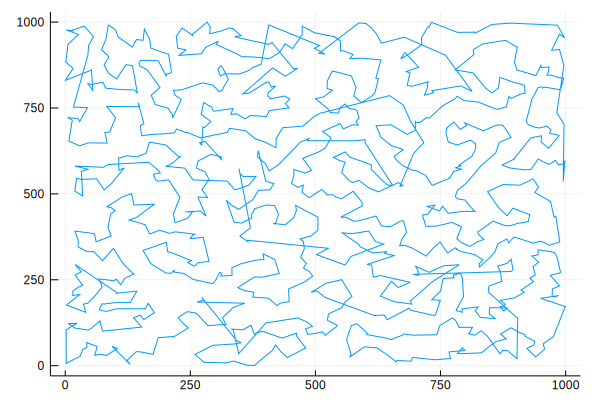

In [18]:
# Draw the solutions
# using Pkg
# Pkg.add("Plots")
using Plots
function draw_aco(twod, aco, cities)
    x = []
    y = []
    ann = []
    for i in 1:cities
        try
            x = vcat(x, twod[1, aco[i]])
            y = vcat(y, twod[2, aco[i]])
#             ann = vcat(ann, (twod[1, aco[i]], twod[2, aco[i]],text(aco[i], 6)))
        catch
            x = [twod[1, aco[i]]]
            y = [twod[2, aco[i]]]
#             ann = [(twod[1, aco[i]], twod[2, aco[i]], text(aco[i], 6))]
        end
    end
    x = vcat(x, twod[1, aco[1]])
    y = vcat(y, twod[2, aco[1]])
#     sleep(1)
    p1 = plot(x, y, label = "", overwrite_figure = "clearfig")
end
# draw the aco solution generated by the program
draw_aco(x,aco,n)